In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from model_functions import *
from data_functions import *
from plotting_functions import *

### Set plotting parameters

In [2]:
# set plotting parameters
font_name = 'Arial'
font_size = 12
tick_size = 10

# set color palette
colors = sns.color_palette("rocket", 6)
order = [2, 3, 5, 1]
colors_4 = [colors[i] for i in order]

# create 28 day gradient 
cmap = LinearSegmentedColormap.from_list("my_gradient", colors_4, N=28)
colors_28 = [cmap(i/20) for i in range(28)]  

### Run and Plot Shank-Only XGBoost Model Validation (Fig. 1c)

In [ ]:
params = {
    # dataset params
    "data_dir" : 'data/model_validation/training_data/',
    "sensor": 'shank',
    "random_split_manual_seed": 1099,
    "shuffle": True,
    "out_path": 'model_validation/results',

    # train/val split dataset
    "train_val_split": 0.9,

    # XGBoost hyperparameters
    'subsample': 0.8,
    'n_estimators': 400,
    'max_depth': 3,
    'eta': 0.05,
    'colsample_bytree': 0.7
}

In [ ]:
# get a description of training cohort (i.e., number of males vs female, BMI, and age)
train_data_path = 'data/model_validation/training_data'

train_subj_info = pd.read_csv('data/model_validation/train_subj_info.csv')
val_subj_info = pd.read_csv('data/model_validation/val_subj_info_SHANK.csv')

# insert bmi column
train_subj_info.insert(5, 'BMI', train_subj_info['weight']/(train_subj_info['height']**2))
val_subj_info.insert(5, 'BMI', val_subj_info['weight']/(val_subj_info['height']**2))

df = pd.concat([train_subj_info, val_subj_info], ignore_index=True)

# identify female subjects and their testing condtions
data_path = os.path.join(params['data_dir'], params['sensor'])
data_list = os.listdir(data_path)                                        

uniq_subj = set(s.split('_')[0] for s in data_list if s.startswith('S'))                                  
uniq_cond = set(s.split('_')[1] for s in data_list if s.startswith('S'))     

uniq_subj_list = sorted(list(uniq_subj))
uniq_cond_list = sorted(list(uniq_cond))

# get list of female subjects and their conditions
fem_subjs = [subj for subj in uniq_subj if df.loc[df['subject'] == subj, 'gender'].iloc[0] == 'F']
fem_conds = [fn for fn in data_list if fn[:3] in fem_subjs]

In [13]:
# train/test xgboost model
MAPE_all = []
MSE_all = []
for val_cond in fem_conds:
    subject = val_cond.split('_')[0]
    print(f'Calculating MAPE for {val_cond}, excluding {subject} from training dataset')

    train_list = [cnd for cnd in data_list if cnd != val_cond and cnd[:3] != subject ]
    
    dataset = load_dataset(params, train_list, [val_cond])

    xgb_regressor = XGBregressor(params)
    MAPE_score, MSE_score = xgb_regressor.predict(dataset)

    MAPE_all.append(MAPE_score)
    MSE_all.append(MSE_score)

MAPE_all_perc = [val*100 for val in MAPE_all]

Calculating MAPE for S39_C18, excluding S39 from training dataset
Calculating MAPE for S09_C08, excluding S09 from training dataset
Calculating MAPE for S39_C20, excluding S39 from training dataset
Calculating MAPE for S09_C06, excluding S09 from training dataset
Calculating MAPE for S10_C11, excluding S10 from training dataset
Calculating MAPE for S38_C20, excluding S38 from training dataset
Calculating MAPE for S38_C18, excluding S38 from training dataset
Calculating MAPE for S09_C07, excluding S09 from training dataset
Calculating MAPE for S39_C21, excluding S39 from training dataset
Calculating MAPE for S13_C11, excluding S13 from training dataset
Calculating MAPE for S15_C19, excluding S15 from training dataset
Calculating MAPE for S15_C21, excluding S15 from training dataset
Calculating MAPE for S15_C17, excluding S15 from training dataset
Calculating MAPE for S14_C11, excluding S14 from training dataset
Calculating MAPE for S01_C11, excluding S01 from training dataset
Calculatin

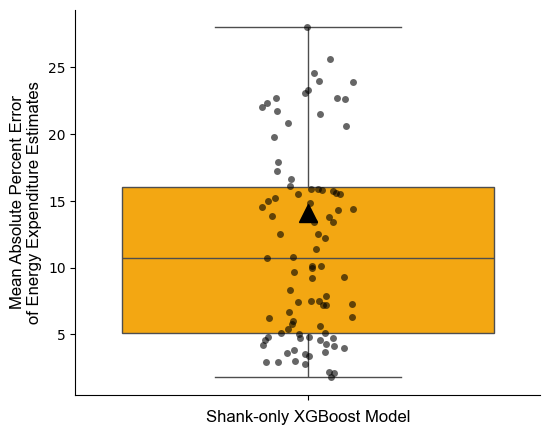

In [15]:
# plot boxplot of MAPE 
fig, ax = plt.subplots(1,1,figsize=(6,5))

sns.boxplot(MAPE_all_perc, color='#F3A712', saturation=1, showmeans=True,showfliers=False, ax=ax, 
            meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                       "markersize":"13"})

MAPE_nofliers = [val for val in sorted(MAPE_all_perc) if val < 30]
sns.stripplot(MAPE_nofliers, color='black', alpha=0.6)

ax.set_xlabel("Shank-only XGBoost Model", fontsize=font_size, fontname=font_name)
ax.set_ylabel("Mean Absolute Percent Error\nof Energy Expenditure Estimates", fontsize=font_size, fontname=font_name)
ax.tick_params(axis='both', which='major', labelsize=tick_size);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Import Energy Expenditure Estimates and Metadata

In [3]:
# Set data and metadata file paths
data_path = 'data/energy_estimates.pkl'
meta_path = 'data/metadata.csv'
phase_path = 'data/phasetable.csv'

# Load Energy Expenditure Estimates
with open(data_path, "rb") as fn: 
    model_estimates = pickle.load(fn)

# Get list of subjects
subjects = [key for key in model_estimates.keys()]

# Import metadata
metadata = pd.read_csv(meta_path)
metadata.insert(3, "BMI", metadata['Weight_kg']/(metadata['Height_m']**2))

# Import phase data
phasedata = pd.read_csv(phase_path)

### Plot differences in activity metrics between cycle phases (Figs. 2a-2c)

In [ ]:
# get active energy expenditure and steps in order of study visits
AEE_kJkg_studyorder, N_steps_df = dct_to_df(model_estimates, subjects, metadata)

# reorder active energy expenditure, steps, and model estimates in order of menstrual cycle (first day of menses -> luteal)
AEE_kJkg_cycleorder, N_steps_cycleorder, model_estimates_cycleorder = sort_df(AEE_kJkg_studyorder, N_steps_df, model_estimates, metadata, phasedata)

# reshape dataframe for plotting purposes
df_wide = reshape_df(AEE_kJkg_cycleorder, N_steps_cycleorder, model_estimates_cycleorder)
df_wide.head()

,subject,phase,study_day,cycle_day,day_from_LH,AEE_kJkg,TEE_W,N_steps
0,S331,Early Follicular,1,1,-14.0,27.481381,313.675446,5006.0
1,S331,Early Follicular,2,2,-13.0,20.039706,306.174805,3857.0
2,S331,Early Follicular,3,3,-12.0,26.159719,383.005524,4245.0
3,S331,Early Follicular,4,4,-11.0,24.250714,297.096100,4657.0
4,S331,Early Follicular,5,5,-10.0,10.229421,310.069366,1744.0


[('Early Follicular', 'Late Follicular'), ('Early Follicular', 'Ovulation'), ('Early Follicular', 'Luteal'), ('Late Follicular', 'Ovulation'), ('Late Follicular', 'Luteal'), ('Ovulation', 'Luteal')]
6
Bonferroni-corrected alpha: 0.008333333333333333
0.007290899753570557
0.11648222804069519
0.21726065874099731
0.6348496079444885
0.6893201172351837
0.670972615480423
[[('Early Follicular', 'Late Follicular'), 0.007290899753570557]]
[[0, 1]]
n subjects: 26


/Users/chelseycampillo/Documents/01_Harvard/01_sladelab/01_research/01_zeitzer_paper/repo/plotting_functions.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_cat, y=metric, ax=ax, order=phases, palette=col_palette, saturation=sat_val, linewidth=1,
/Users/chelseycampillo/Documents/01_Harvard/01_sladelab/01_research/01_zeitzer_paper/repo/plotting_functions.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=font_size, fontname='Arial')
/Users/chelseycampillo/Documents/01_Harvard/01_sladelab/01_research/01_zeitzer_paper/repo/plotting_functions.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrapped_labels)


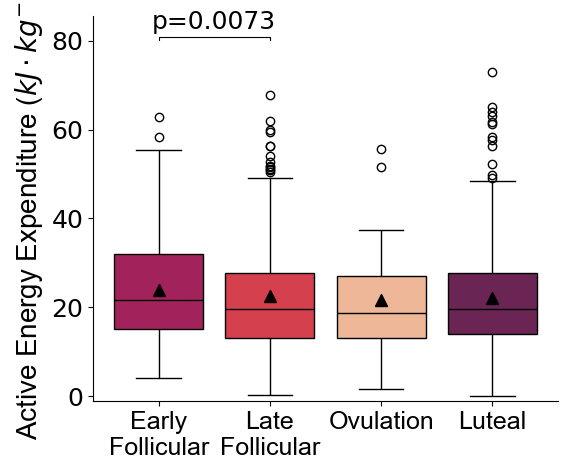

In [5]:
pairs = ["Early Follicular", "Late Follicular","Ovulation","Luteal"]
ylabel = r'Active Energy Expenditure ($kJ \cdot kg^{-1}$)'
xlabels = pairs

# compare across phases (EVERYONE)
compare_phases(df_wide, 'AEE_kJkg', 'phase', pairs, [-1,75], ylabel, xlabels, 
                col_palette=colors_4, sat_val=0.85, figsize=(6,5),
                save_fig=False, fig_title='boxplot_phases_everyone_n26.svg')

[('Early Follicular', 'Late Follicular')]
1
Bonferroni-corrected alpha: 0.05


/Users/chelseycampillo/Documents/01_Harvard/01_sladelab/01_research/01_zeitzer_paper/repo/plotting_functions.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_cat, y=metric, ax=ax, order=phases, palette=col_palette, saturation=sat_val, linewidth=1,
/Users/chelseycampillo/Documents/01_Harvard/01_sladelab/01_research/01_zeitzer_paper/repo/plotting_functions.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=font_size, fontname='Arial')
/Users/chelseycampillo/Documents/01_Harvard/01_sladelab/01_research/01_zeitzer_paper/repo/plotting_functions.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrapped_labels)


0.023610919713974
[[('Early Follicular', 'Late Follicular'), 0.023610919713974]]
[[0, 1]]
n subjects: 26


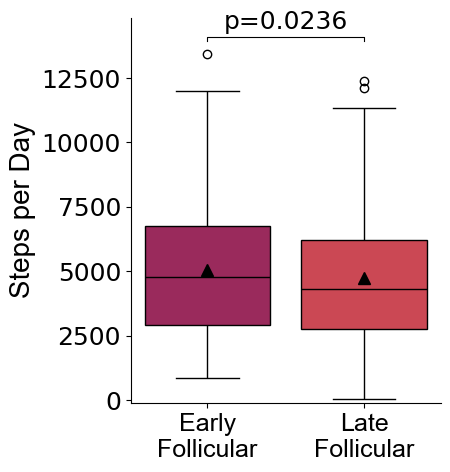

In [6]:
pairs = ["Early Follicular", "Late Follicular"]
ylabel = r'Steps per Day'
xlabels = pairs

colors_2 = colors_4[0:2]

# compare between follicular and luteal (EVERYONE)
compare_phases(df_wide, 'N_steps', 'phase', pairs, [-100,13000], ylabel, xlabels,
               col_palette=colors_2, sat_val=0.75, figsize=(4,5),
               save_fig=False, fig_title='boxplot_EarLatFoll_nSteps_everyone_n26.svg')

[('Early Follicular', 'Late Follicular')]
1
Bonferroni-corrected alpha: 0.05
0.3940727114677429
[]
[]
n subjects: 26


/Users/chelseycampillo/Documents/01_Harvard/01_sladelab/01_research/01_zeitzer_paper/repo/plotting_functions.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_cat, y=metric, ax=ax, order=phases, palette=col_palette, saturation=sat_val, linewidth=1,
/Users/chelseycampillo/Documents/01_Harvard/01_sladelab/01_research/01_zeitzer_paper/repo/plotting_functions.py:53: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.boxplot(data=df, x=x_cat, y=metric, ax=ax, order=phases, palette=col_palette, saturation=sat_val, linewidth=1,
/Users/chelseycampillo/Documents/01_Harvard/01_sladelab/01_research/01_zeitzer_paper/repo/plotting_functions.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=font_size, fontname='Arial'

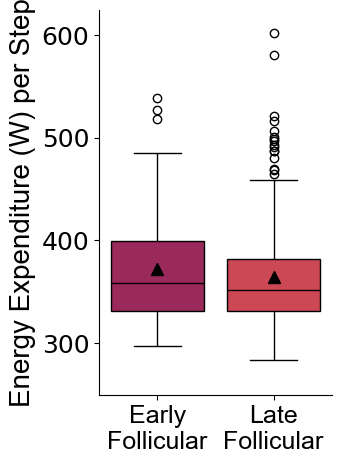

In [7]:
pairs = ["Early Follicular", "Late Follicular"]
ylabel = 'Energy Expenditure (W) per Step'
xlabels = ["Early Follicular", "Late Follicular"]

compare_phases(df_wide, 'TEE_W', 'phase', pairs, [250, 600],  ylabel, xlabels,
               col_palette=colors_4, sat_val=0.75, figsize=(3,5),
               save_fig=True, fig_title='boxplot_EarLatFoll_nSteps_everyone_n26.svg')

### Plot active energy expenditure across cycle days (Fig. 2d)

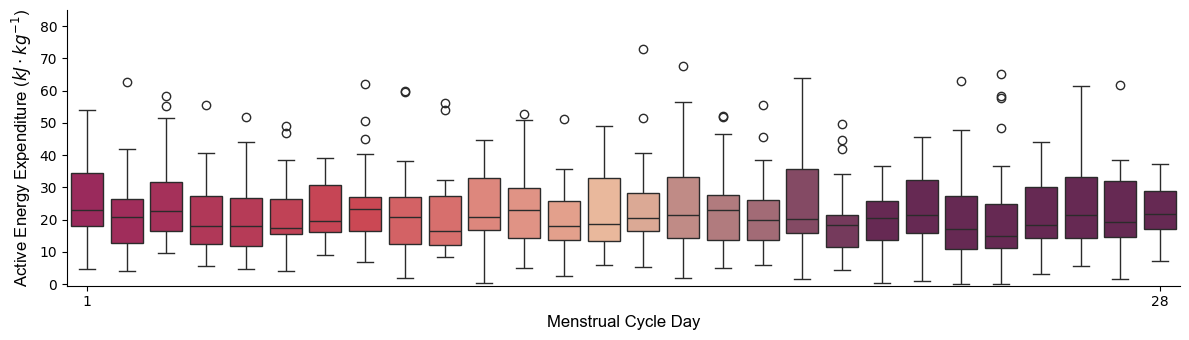

In [8]:
fig, axes = plt.subplots(1,1,figsize=(12,3.5))

sns.boxplot(data=AEE_kJkg_cycleorder[np.arange(1,29)],palette=colors_28, ax=axes)
axes.set_ylabel(r"Active Energy Expenditure ($kJ \cdot kg^{-1}$)", fontname=font_name, fontsize=font_size)
axes.set_xlabel('Menstrual Cycle Day', fontname=font_name, fontsize=font_size)
axes.set_xticks([0, 27])
axes.tick_params(axis='both', which='major', labelsize=tick_size) 
axes.set_ylim([-0.5, 85])
axes.spines[['top','right']].set_visible(False)

plt.tight_layout()
#plt.savefig('./figures/AEE_kJkg_cycleorder_boxplot.svg', dpi=600)

### Plot estradiol, progesterone, and AEE with respect to ovulation (Fig 3a)

**Estradiol value citations**
* Dighe, A. S., Moy, J. M., Hayes, F. J. & Sluss, P. M. High-resolution reference ranges for estradiol, luteinizing hormone, and follicle-stimulating hormone in men and women using the AxSYM assay system. Clin. Biochem. 38, 175–179 (2005).
* Stricker, R. et al. Establishment of detailed reference values for luteinizing hormone, follicle stimulating hormone, estradiol, and progesterone during different phases of the menstrual cycle on the Abbott ARCHITECT analyzer. Clin. Chem. Lab. Med. 44, 883–887 (2006).
* Verdonk, S. J. E. et al. Estradiol reference intervals in women during the menstrual cycle, postmenopausal women and men using an LC-MS/MS method. Clin. Chim. Acta 495, 198–204 (2019).

**Source of progesterone values**
* Stricker, R. et al. Establishment of detailed reference values for luteinizing hormone, follicle stimulating hormone, estradiol, and progesterone during different phases of the menstrual cycle on the Abbott ARCHITECT analyzer. Clin. Chem. Lab. Med. 44, 883–887 (2006).

**Cohort Demographics**
| Study | n | Age | BMI | Menstrual Status |
|:------|:-:|:---:|:---:|:----------------:|
|Dighe et al., 2005 | 51 | 18-35 years | 18-35 kg/m^2 | Eumenorrheic |
|Stricker et al., 2006 | 20 | 20-36 years | n/a | Eumenorrheic |
|Verdonk et al., 2005 | 30 | 18-39 years | 18-28.8 kg/m^2 | Eumenorrheic |
|current study | 26 | 20-27 years | 20-28 kg/m^2 | Eumenorrheic |

In [9]:
hormone_path = 'data/hormone_reference_values.csv'
df_hormones = pd.read_csv(hormone_path)
df_hormones = df_hormones.rename(columns={'Day_from_LH_peak': 'day_from_LH'})
df_hormones = df_hormones.iloc[:-1]

In [10]:
Dighe_5th_E2_pmolL = []
Dighe_95th_E2_pmolL = []

for i in range(len(df_hormones['Lower_99_E2_pmolL_Dighe'])):
    mean = df_hormones['Mean_E2_pmolL_Dighe'][i]
    ci99_upper = df_hormones['Upper_99_E2_pmolL_Dighe'][i]
    n = df_hormones['n_E2_Dighe'][i]

    ci95 = ci_95_from_99_t(mean, ci99_upper, n)
    Dighe_5th_E2_pmolL.append(ci95[0])
    Dighe_95th_E2_pmolL.append(ci95[1])

# insert Dighe_5th_E2_pmolL and Dighe_95th_E2_pmolL into all_hormones DataFrame
df_hormones['5th_E2_pmolL_Dighe'] = Dighe_5th_E2_pmolL
df_hormones['95th_E2_pmolL_Dighe'] = Dighe_95th_E2_pmolL

In [11]:
LH_df = df_wide.sort_values(by='day_from_LH')
maskLH = LH_df['day_from_LH'].isin(np.arange(-15,15))
LH_df = LH_df[maskLH]
LH_df.head()

,subject,phase,study_day,cycle_day,day_from_LH,AEE_kJkg,TEE_W,N_steps
449,S100,Early Follicular,9,2,-15.0,4.165922,305.577301,890.0
334,S141,Early Follicular,10,1,-15.0,20.870147,340.753479,4568.0
503,S166,Early Follicular,16,4,-15.0,18.868159,361.429840,5793.0
661,S059,Early Follicular,19,1,-15.0,37.946404,352.434448,8567.0
195,S318,Early Follicular,4,1,-15.0,27.303781,386.007690,5271.0


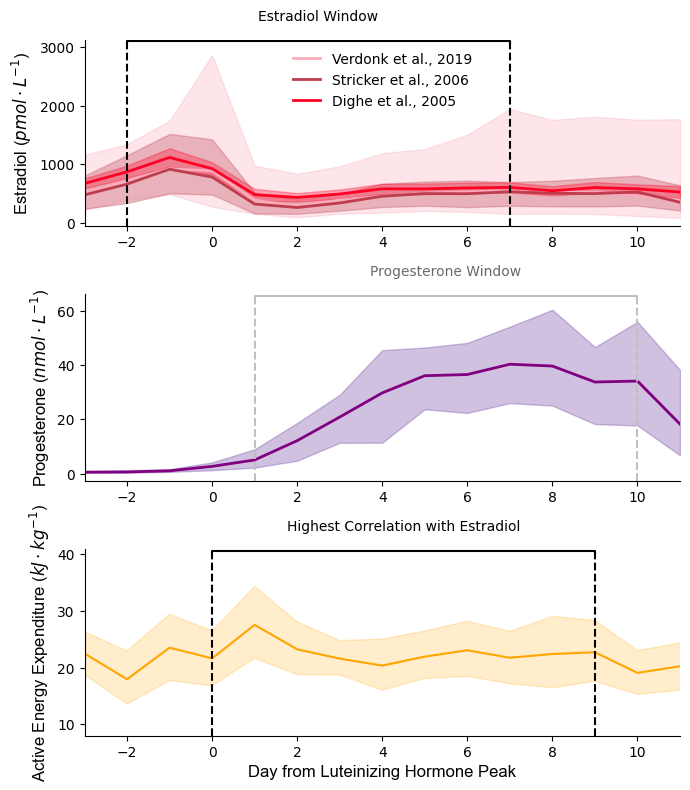

In [12]:
# Plot AEE (kJ/kg), [E2], and [P4]
palette_E2 = ['#FF0025',"#BE3D4D","#FAAABA"]
dighe_color = palette_E2[0]
stricker_color = palette_E2[1]
verdonk_color = palette_E2[2]   

palette2 = ['orange','#D7706E','purple']

fig, ax = plt.subplots(3,1,figsize=(7,8))     

# plot [E2] from three sources:                     
# (3) plot E2 mean and CI from Verdonk
ax[0].fill_between(df_hormones['day_from_LH'].iloc[12:27], df_hormones['Lower_95_E2_pmolL_Verdonk'].iloc[12:27], df_hormones['Upper_95_E2_pmolL_Verdonk'].iloc[12:27], color=palette_E2[2], alpha=0.3)
ax[0].plot(df_hormones['day_from_LH'].iloc[12:27], df_hormones['Mean_E2_pmolL_Verdonk'].iloc[12:27], color=palette_E2[2], linewidth=2, label='Verdonk et al., 2019')
# (1) plot E2 mean and CI from Stricker
ax[0].fill_between(df_hormones['day_from_LH'].iloc[12:27], df_hormones['5th_E2_pmolL_Stricker'].iloc[12:27], df_hormones['95th_E2_pmolL_Stricker'].iloc[12:27], color=palette_E2[1], alpha=0.3)
ax[0].plot(df_hormones['day_from_LH'].iloc[12:27], df_hormones['Mean_E2_pmolL_Stricker'].iloc[12:27], color=palette_E2[1], linewidth=2, label='Stricker et al., 2006')
# (2) plot E2 mean and CI from Dighe
ax[0].fill_between(df_hormones['day_from_LH'].iloc[12:27], df_hormones['5th_E2_pmolL_Dighe'].iloc[12:27], df_hormones['95th_E2_pmolL_Dighe'].iloc[12:27], color=palette_E2[0], alpha=0.3)
ax[0].plot(df_hormones['day_from_LH'].iloc[12:27], df_hormones['Mean_E2_pmolL_Dighe'].iloc[12:27], color=palette_E2[0], linewidth=2, label='Dighe et al., 2005')
ax[0].legend(frameon=False)

# plot [P4]
ax[1].fill_between(df_hormones['day_from_LH'].iloc[12:27], df_hormones['5th_P4_nmolL_Stricker'].iloc[12:27], df_hormones['95th_P4_nmolL_Stricker'].iloc[12:27], color='rebeccapurple', alpha=0.3, label='5th-95th Percentile')
ax[1].plot(df_hormones['day_from_LH'].iloc[12:27], df_hormones['Mean_P4_nmolL_Stricker'].iloc[12:27], color=palette2[2], linewidth=2, label='Mean')

# plot AEE
sns.lineplot(data=LH_df[(LH_df['day_from_LH'] >= -2) | (LH_df['day_from_LH'] <= 10)], x='day_from_LH',y='AEE_kJkg', color=palette2[0], ax=ax[2])  

# add estradiol window dashed lines
x1 = -2
x2 = 7
x_values_for_lines = [x1, x2]
for x_val in x_values_for_lines:
    ax[0].axvline(x=x_val, color='black', linestyle='--', linewidth=1.5)
    
bottom, top = ax[0].get_ylim()
y_range = top - bottom
extra_y = y_range * 0.04
ax[0].set_ylim(bottom, top + extra_y)  
level = 1
bar_height = top + (y_range * 0.03 * level)  
bar_tips = bar_height - (y_range * 0.01)
idx_pair_plotting = [(x1,x2)]
ax[0].plot(
    [x1, x1, x2, x2],
    [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k')
text_height = bar_height + (y_range * 0.1)
ax[0].text((idx_pair_plotting[0][0] + idx_pair_plotting[0][1]) * 0.5 , text_height, f'Estradiol Window', ha='center', va='bottom', c='k', fontsize=tick_size)

# add progesterone window dashed lines
x1 = 1
x2 = 10
x_values_for_lines = [x1, x2]
for x_val in x_values_for_lines:
    ax[1].axvline(x=x_val, color='silver', linestyle='--', linewidth=1.5)

bottom, top = ax[1].get_ylim()
y_range = top - bottom
extra_y = y_range * 0.04 
ax[1].set_ylim(bottom, top + extra_y) 
level = 1
bar_height = top + (y_range * 0.03 * level)  
bar_tips = bar_height - (y_range * 0.01)
idx_pair_plotting = [(x1,x2)]
ax[1].plot(
    [x1, x1, x2, x2],
    [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='silver')
text_height = bar_height + (y_range * 0.1)
ax[1].text((idx_pair_plotting[0][0] + idx_pair_plotting[0][1]) * 0.5 , text_height, f'Progesterone Window', ha='center', va='bottom', c='dimgrey', fontsize=tick_size)

# add AEE window dashed lines
x1 = 0
x2 = 9
x_values_for_lines = [x1, x2]
for x_val in x_values_for_lines:
    ax[2].axvline(x=x_val, color='k', linestyle='--', linewidth=1.5)

bottom, top = ax[2].get_ylim()
y_range = top - bottom
extra_y = y_range * 0.04 
ax[2].set_ylim(bottom, top + extra_y) 
level = 1
bar_height = top + (y_range * 0.03 * level)  
bar_tips = bar_height - (y_range * 0.01)
idx_pair_plotting = [(x1,x2)]
ax[2].plot(
    [x1, x1, x2, x2],
    [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k')
text_height = bar_height + (y_range * 0.1)
ax[2].text((idx_pair_plotting[0][0] + idx_pair_plotting[0][1]) * 0.5 , text_height, f'Highest Correlation with Estradiol', ha='center', va='bottom', c='k', fontsize=tick_size)



ax[0].set_xlim([-3,11])
ax[1].set_xlim([-3,11])
ax[2].set_xlim([-3,11])

ax[2].set_ylabel(r"Active Energy Expenditure ($kJ \cdot kg^{-1}$)", fontname='Arial', fontsize=font_size)
ax[0].set_ylabel(r'Estradiol ($pmol \cdot L^{-1}$)',fontname='Arial', fontsize=font_size)
ax[1].set_ylabel(r'Progesterone ($nmol \cdot L^{-1}$)',fontname='Arial', fontsize=font_size)

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('Day from Luteinizing Hormone Peak',fontname='Arial', fontsize=font_size)

ax[0].tick_params(axis='both', labelsize=tick_size)
ax[1].tick_params(axis='both', labelsize=tick_size)
ax[2].tick_params(axis='both', labelsize=tick_size)


ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[2].spines[['right', 'top']].set_visible(False)

plt.tight_layout()

### Plot dot product and r-squared values across AEE lags (Fig 3b & 3c)

In [13]:
# merge hormone, AEE, and metadata into one dataframe
E2_stricker, E2_dighe,  E2_verdonk, P4_stricker = [],[],[],[]

for idx in range(len(LH_df)):
    day_from_LH = LH_df['day_from_LH'].iloc[idx]

    E2_stricker_val = df_hormones['Mean_E2_pmolL_Stricker'][df_hormones['day_from_LH'] == day_from_LH].values[0]
    E2_dighe_val = df_hormones['Mean_E2_pmolL_Dighe'][df_hormones['day_from_LH'] == day_from_LH].values[0]
    E2_verdonk_val = df_hormones['Mean_E2_pmolL_Verdonk'][df_hormones['day_from_LH'] == day_from_LH].values[0]
    P4_Stricker_val = df_hormones['Mean_P4_nmolL_Stricker'][df_hormones['day_from_LH'] == day_from_LH].values[0]

    E2_stricker.append(E2_stricker_val)
    E2_dighe.append(E2_dighe_val)
    E2_verdonk.append(E2_verdonk_val)
    P4_stricker.append(P4_Stricker_val)
    
LH_df.insert(8, 'E2_pmolL_Stricker', E2_stricker)
LH_df.insert(9, 'E2_pmolL_Dighe', E2_dighe)
LH_df.insert(10, 'E2_pmolL_Verdonk', E2_verdonk)
LH_df.insert(11, 'P4_nmolL_Stricker', P4_stricker)

LH_df.head()

,subject,phase,study_day,cycle_day,day_from_LH,AEE_kJkg,TEE_W,N_steps,E2_pmolL_Stricker,E2_pmolL_Dighe,E2_pmolL_Verdonk,P4_nmolL_Stricker
449,S100,Early Follicular,9,2,-15.0,4.165922,305.577301,890.0,118.42,202,112.0,1.66
334,S141,Early Follicular,10,1,-15.0,20.870147,340.753479,4568.0,118.42,202,112.0,1.66
503,S166,Early Follicular,16,4,-15.0,18.868159,361.429840,5793.0,118.42,202,112.0,1.66
661,S059,Early Follicular,19,1,-15.0,37.946404,352.434448,8567.0,118.42,202,112.0,1.66
195,S318,Early Follicular,4,1,-15.0,27.303781,386.007690,5271.0,118.42,202,112.0,1.66


In [14]:
LH_mean_df = (LH_df.groupby('day_from_LH')[['AEE_kJkg', 'E2_pmolL_Stricker', 'E2_pmolL_Dighe','E2_pmolL_Verdonk','P4_nmolL_Stricker']].mean().reset_index())
LH_mean_df.head()

,day_from_LH,AEE_kJkg,E2_pmolL_Stricker,E2_pmolL_Dighe,E2_pmolL_Verdonk,P4_nmolL_Stricker
0,-15.0,28.455317,118.42,202.0,112.0,1.66
1,-14.0,27.196645,133.01,198.0,121.0,1.27
2,-13.0,24.055775,133.17,239.0,122.0,1.02
3,-12.0,21.912658,125.95,213.0,121.0,0.82
4,-11.0,19.813102,134.65,209.0,125.0,0.74


In [15]:
# run dot product for estradiol days -2 to +7
n = 2
idx = [13,23]
pairs = [['E2_pmolL_Stricker','AEE_kJkg'],
         ['E2_pmolL_Dighe','AEE_kJkg'],
         ['E2_pmolL_Verdonk','AEE_kJkg']]

r2_scores_shift, dot_pdt_shift = [],[]
for pair in pairs:
    print(pair)
    r2, dt_pdt = compare_r2_dot(LH_mean_df, idx, [pair], show_fig=False, save_fig=False, savevals=True)
    r2_scores_shift.append(r2)
    dot_pdt_shift.append(dt_pdt)

# create a dictionary with the first index of each tuple in r2_scores_shift as a key and the value is an array containing the second index. for example, 0 key should contain the following array: [0.05980155028016243, 0.052512921396056345, 0.04923960364884361]
r2_scores_dict = {}
dt_pdt_dict = {}
for i in range(len(r2_scores_shift[0])):
    r2_scores_dict[i] = [r2_scores_shift[j][i][1] for j in range(len(r2_scores_shift))] 
    dt_pdt_dict[i] = [dot_pdt_shift[j][i][1] for j in range(len(dot_pdt_shift))]

# take mean of each array in r2_scores_dict and dt_pdt_dict
r2_scores_mean = {k: np.mean(v) for k, v in r2_scores_dict.items()}
dt_pdt_mean = {k: np.mean(v) for k, v in dt_pdt_dict.items()}   
r2_scores_mean

['E2_pmolL_Stricker', 'AEE_kJkg']
['E2_pmolL_Dighe', 'AEE_kJkg']
['E2_pmolL_Verdonk', 'AEE_kJkg']


{0: 0.08006667993136445,
 1: 0.22292851726176466,
 2: 0.6010081919879116,
 3: 0.11767309280531402,
 4: 0.04668141729327154}

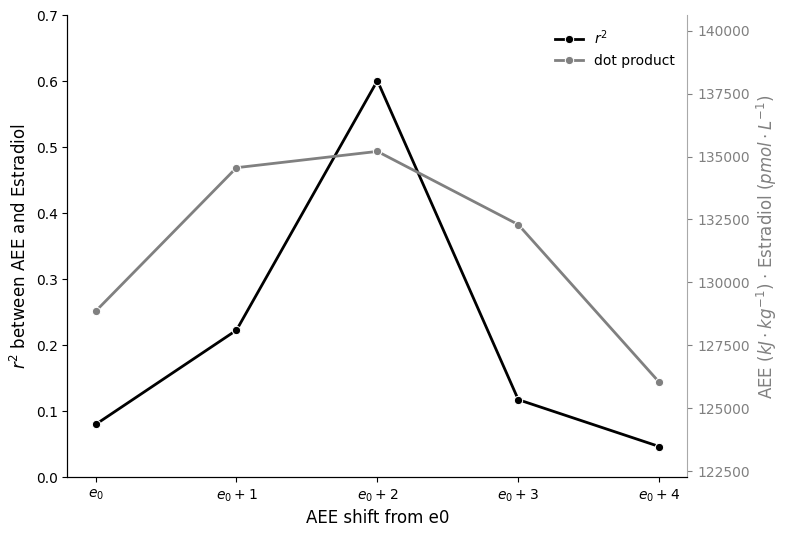

In [16]:
# PLOT
fig, ax = plt.subplots(1,1,figsize=(8,6))

sns.lineplot(x=r2_scores_mean.keys(), y=r2_scores_mean.values(), color="black",linewidth=2,label=r'$r^2$', legend=False, marker='o', ax=ax)
tick_locations = [0, 1, 2, 3, 4]
tick_labels = [r'$e_0$', r'$e_0 + 1$', r'$e_0 + 2$', r'$e_0 + 3$', r'$e_0 + 4$']
ax.set_xticks(tick_locations, tick_labels) 
ax.tick_params(axis='both', labelsize=tick_size)
ax.set_xlabel(f'AEE shift from e0', fontsize=font_size)
ax.set_ylabel(r"$r^2$ between AEE and Estradiol", fontsize=font_size) 
ax.set_ylim(0,0.7)
ax.spines[['right','top']].set_visible(False)
ax.grid(False)

# plot dot product
ax2 = ax.twinx()
sns.lineplot(x=dt_pdt_mean.keys(), y=dt_pdt_mean.values(), color='grey',linewidth=2, label='dot product',marker='o', ax=ax2)
ax2.tick_params(axis='both', labelsize=tick_size) 
ax2.set_xticks([key for key in dt_pdt_mean.keys()])
ax2.set_ylabel(r"AEE ($kJ \cdot kg^{-1}$) $\cdot$ Estradiol ($pmol \cdot L^{-1}$)", fontsize=font_size, color='grey')
ax2.set_ylim(min(dt_pdt_mean.values())*0.9, max(dt_pdt_mean.values())*1.1)
ax2.spines[['top']].set_visible(False)
ax2.spines[['right']].set_color("darkgrey")
ax2.tick_params(axis='y', colors="grey")
ax2.set_ylim([min(dt_pdt_mean.values())*0.97, max(dt_pdt_mean.values())*1.04])
ax2.grid(False)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper right',frameon=False, fontsize=tick_size);

#plt.savefig('./figures/mean_R2_dtpdt_for_E2.svg', dpi=600)

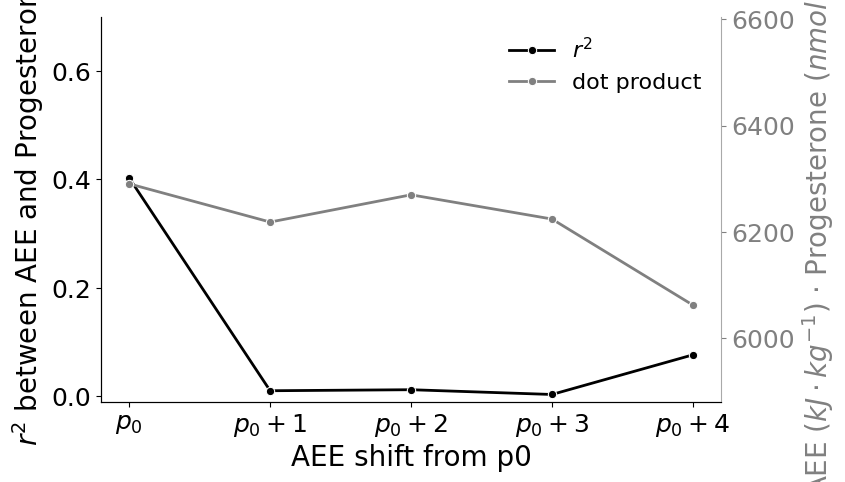

In [17]:
# run dot product for progesterone (0,6)
pairs = [['P4_nmolL_Stricker','AEE_kJkg']]
idx = [16,26]

compare_r2_dot(LH_mean_df, idx, pairs, show_fig=True, save_fig=False)

### Plot correlation between AEE and each source of estradiol reference values (Fig. 3d)

E2_pmolL_Stricker AEE_kJkg
E2_pmolL_Dighe AEE_kJkg
E2_pmolL_Verdonk AEE_kJkg


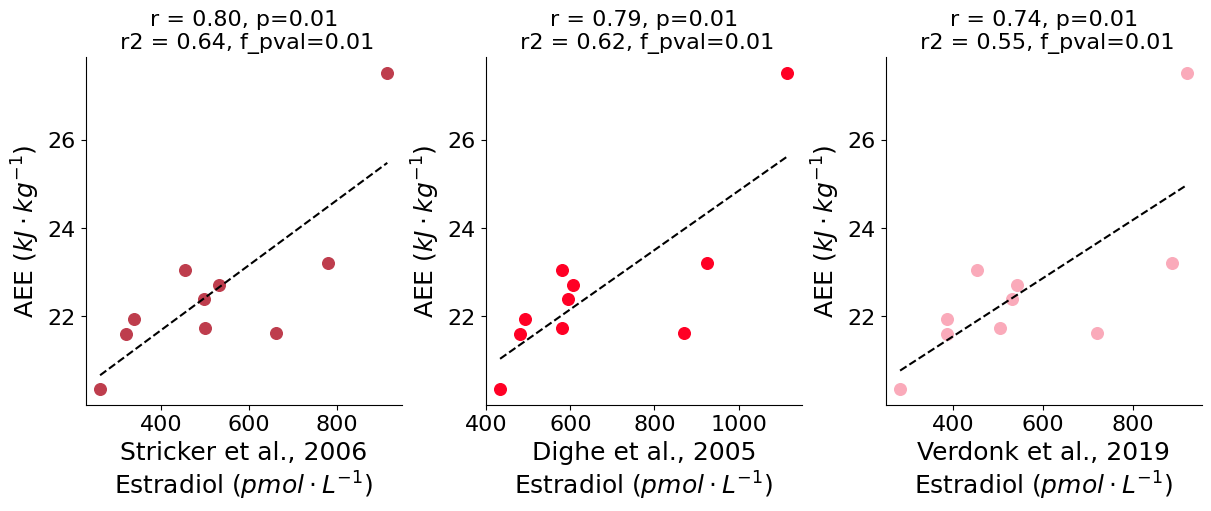

In [18]:
# correlation plots: AEE and [E2]
pairs_data = [['E2_pmolL_Stricker','AEE_kJkg'],
              ['E2_pmolL_Dighe','AEE_kJkg'],
              ['E2_pmolL_Verdonk','AEE_kJkg']]
paper_colors = [stricker_color, dighe_color, verdonk_color]
x_labels = [f'Stricker et al., 2006\n'r'Estradiol ($pmol \cdot L^{-1}$)', f'Dighe et al., 2005\n'r'Estradiol ($pmol \cdot L^{-1}$)', f'Verdonk et al., 2019\n'r'Estradiol ($pmol \cdot L^{-1}$)']
y_label = r'AEE ($kJ \cdot kg^{-1}$)'

idx = [13,23]
n = 2

E2_days = np.array(LH_mean_df['day_from_LH'].iloc[idx[0]:idx[1]])
AEE_days = np.array(LH_mean_df['day_from_LH'].iloc[idx[0]+n:idx[1]+n])

r2_scores_shifted = run_regression(LH_mean_df, pairs_data, arr1=None, arr2=None, idx=idx, n=n, group='all', figsize=(12,5), showplot=True, x_labels=x_labels, y_label=y_label,
                scatter_colors=paper_colors,resplot=False,
                suptitle1 = f"Correlation between [E2] and AEE, all participants (n={len(LH_df['subject'].unique())})\n [E2] days: {E2_days}\n AEE days: {AEE_days}",
                suptitle2 = f"Residual plots, all participants (n={len(LH_df['subject'].unique())})\n [E2]days: {E2_days}\n AEE days: {AEE_days}",
                savevals=True, save_fig=False, title1='corr_E2_AEE_allsources.svg')

r2_array_shifted = [r2[2] for r2 in r2_scores_shifted]

### Plot correlation between AEE and progesterone reference values (Fig. 3e)

P4_nmolL_Stricker AEE_kJkg


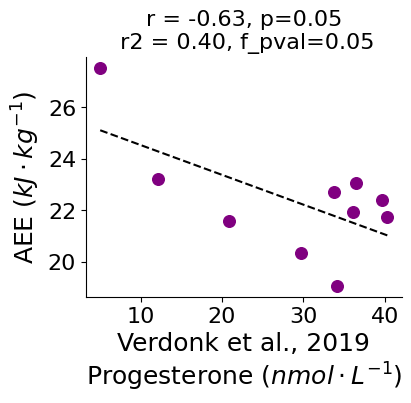

In [19]:
# correlation plots: AEE and [P4]
pairs_data = [['P4_nmolL_Stricker','AEE_kJkg']]
idx = [16,26]
n = 0
E2_days = np.array(LH_mean_df['day_from_LH'].iloc[idx[0]:idx[1]])
AEE_days = np.array(LH_mean_df['day_from_LH'].iloc[idx[0]+n:idx[1]+n])
x_labels = f"Verdonk et al., 2019\n"r'Progesterone ($nmol \cdot L^{-1}$)'

run_regression(LH_mean_df, pairs_data, arr1=None, arr2=None, idx=idx, n=n, group='all', figsize=(4,4), showplot=True, x_labels=x_labels, y_label=y_label,
                scatter_colors=['purple'],resplot=False,
                suptitle1 = f"",
                savevals=False, save_fig=False, title1='corr_E2_AEE_allsources.svg')